## Initialize Main Function and Global Variables

In [1]:
#Import relevant Classes!
import descarteslabs as dl
import descarteslabs.workflows as wf
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import config
from gzip import compress, decompress
from descarteslabs import Storage,Auth
from descarteslabs.workflows.models.exceptions import JobTimeoutError
from multiprocessing.pool import ThreadPool
from descarteslabs.scenes import AOI
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input 
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
import sys
!{sys.executable} -m pip install kneed
from kneed import KneeLocator
from shapely.wkt import loads
import random
from tqdm.notebook import tqdm
sys.path.append('../Predicted_Datasets/')

/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [2]:
#Set a number of global parameters for the entire form, edit this to specifications
#Size of input image for the vggmodel initialization
LOWIMGSHAPE=64
#Number of images to be put into the Kmeans algorithm.  Active memory limited to 2500 with a pair of 64*64*3 and 640*640*3 satellite images and a feature set of 2*2*512, test or adjust at will
BATCHSIZE=2250
#Maximum number of groups to separate images into during the kmeans step.  Usually between 5-10 but this depends on input image and the feature extraction process, test or adjust at will 
KMEANSSIZE=50
#Time alloted for satellite image query in seconds. Increase or decrease at will, recommended to ensure a timeout to prevent lockout during the threadpooling.
TIMEOUT=420
#Name of the current dataset, change as needed
datasetName='updatedModel_state_sampled_happy_cow'

In [3]:
"""
The initiate model is a function that takes a set of descartelabs geospatial keys and queries the s2 and ab satellites for a low and high resolution image
using threadpooling and consequently extracts features from the lower resolution image using the keras VGG model.  The images are then saved into a descarteslabs
storage as gzip compressed pickle dumps and the features are then passed onto a PCA, optimizing on number of features before being passed onto a KMeans clustering
which optimizes over the number of clusters and finally creating a gzip pickle dumped dictionary of groupings with keys as values into the storage item.

INPUT
    randomKeyPairs->
        list[...,string(),string(),string(),...]
        Takes as input a list of strings representing descarteslabs keys, incorrect keys or initialization is not tested
    batch->
        int()
        Takes as input an integer representing the current batch this randomKeyPairs represents in the dataset, serves to name the storage objects to keep track of
        the current dictionary.  Repeated use of the same batch integer results in overwriting existing datasets, ensure the datasetName is accurate and the batch
        correct or previous data is not important.
RETURNS
    None
        Has no return but does save onto an initialized descartes labs storage object three gzip compressed pickle dumped dictionaries.
           -datasetName+'GroupBatch'+str(batch) -> ex 'worried_puppyGroupBatch0'
            Represents the key to a dictionary that has stringified integers as keys for lists of string descarteslabs keys
                dict{
                    ...,
                    string(int()):list[...,string(),string(),string()...],
                    string(int()):list[...,string(),string(),string()...],
                    ...
                }
           -datasetName+'HrBatch'+str(batch) -> ex 'worried_puppyHrBatch0'
            Represnts the key to a dictionary that has string descarteslabs keys as keys and numpy ndarrays, of a shape dictated by the satellite initiated,
            with UINT8 values ranging from (0-255)
                dict{
                    ...,
                    string():numpy.ndarray[],
                    string():numpy.ndarray[],
                    ...
                }
           -datasetName+'LrBatch'+str(batch) -> ex 'worried_puppyLrBatch0'
            Identical to the HrBatch dictionary but filled with the lower resolution images
WORKFLOW
   -Create empty pair of dictionaries for High and Low Resolution Images intialized to each descarteslabs Key provided in randomKeyPairs with None
   -Initiate VGG model with input shape as defined in the globals above, and pair of satellites ab and s2 with RGB bands
   -Separate the randomKeyPairs dictionary into 20 batches and feed those groupings to the gethrimage function and iterate through them to display progress between
    threadpooling
       -gethrimage-Create a DLTile from the key provided and attempt to obtain a 0-255 ndarray representation of the High and Low resolution images and then saving 
        those to their respective dictionaries.  Finally, pass the lower resolution image to the extract features function and save the features to a dictionary.
        Images that fail to load in the alloted TIMEOUT time or return a None type ndarray are skipped and continue to be None in both their dictionaries
           -extract_features-Reshape the image ndarray to (1,64,64,3) and use the preprocess_input function of the keras model and pass that through the initialized
            VGG16 model, returning the features in shape (2,2,512).
   -Save the dictionaries as compressed gzip pickle dumped bytes under the above names and clear the dictionaries to save some active memory
   -Pass and reshape the features (numSuccessfulKeys,2048) stored in data to the PCA and optimize using the value of features with the highest sequential variance
    difference.  Run the PCA one more time using that value and extract the shortened feature list and clear the original feature list.
   -Iterate through KMEANSSIZE number of Kmeans algorithm groupings to obtain the inertia values of the PCA shortened feature set optimized into x groups.  Use kneed
    to locate the best number of groupings to intialize for this dataset and run one more Kmeans algorithm at that value.
   -Create the grouping dictionary setting each key to its respective Kmeans grouping and upload its gzip compressed pickle dumped bytes to the storage object
KNOWN_ISSUES
   -This function is highly limited by active memory size since each high resolution image is 10x the size of the low res image and storing these in dictionaries is
    memory intensive, more optimal ways of storing these images would be beneficial
   -The acquisition of images from the Tiles has several known issues:
       -For some reason, certain specific images are known to never actively return anything from the compute function, keeping the thread locked for all eternity.
        This is currently solved using a TIMEOUT value during the compute process to early terminate the thread but this:
           -Cuts off images that would otherwise normally terminate and return an actual image
           -Creates issues with descartelabs satellites being momentarily down or images being put in the QUEUE system which would eventually actually run
       -Certain keys are known to return None type values in the ndarray section of the ImageResult which must be individually tested with it's high or low resolution
        companion to ensure proper storage and avoid clashing during the labeling step of the process.  This might be due to no available images being created using
        the specified satellite parameters but it's not clear, investigate at will but not actively detrimental with larger datasets
       -Certain keys are known to return half-loaded/cut-off images for the higher resolution, often leaving a large black void in the bottom of the image, no known
        solution or understanding why given the completeness of low resolution images
   -Sheer size of feature sets have been known to highly limit the active memory allowed crashing the kernel.  Currently solved by actively erasing and clearing
    unecessary dictionaries and data structures as well as, and most importantly, using the lower resolution images for the VGG model.  This can be limiting for the 
    feature extraction step and may not give fantastic grouping results for the Kmeans algorithm, further testing and may be necessary to better fit the data.
   -This function is incredibly time intensive, taking about an hour and some change to run through a 2500 batch of keys.  The issue arises from descartes workflows
    limiting the time a given job is allowed to run and on larger datasets creating unexpected stopping points.  Additionally, on occasion extra kernels are known to
    crash this kernel and create unexpected stopping points.  This is currently offset by manually restarting from the last batch during initialization but can create
    large wastes of time if the program is not supervised.
   -Memory shortages are also known to create crashes but the current parameters are known to work indefinitely, any changes should be noted and balanced alongside
    each other to ensure "smooth" usage.
   -It has been confirmed that descarteslabs limits the size and number of entries allowed in its storage.  The maximal size of an entry is not known but has resulted
    in using compression to ensure proper size limitations which may change given the data's compressionability and the size of the data.  Under current parameters no
    issues are known but altering values may result in meeting these limits.  Additionally descarteslabs storage has an entry limit of 1000 and with 3 entries being
    created per batch, it should be known that currently the storage will run out in 333 batches in a clear storage and likely less if other values/factors are being
    stored in there.  This should also be known if the batchsize is altered and to ensure a proper accumulation of data.  That is to say clear the storage on occassion
    or use some other form of data storage and beware any changes made here.
"""

'\nThe initiate model is a function that takes a set of descartelabs geospatial keys and queries the s2 and ab satellites for a low and high resolution image\nusing threadpooling and consequently extracts features from the lower resolution image using the keras VGG model.  The images are then saved into a descarteslabs\nstorage as gzip compressed pickle dumps and the features are then passed onto a PCA, optimizing on number of features before being passed onto a KMeans clustering\nwhich optimizes over the number of clusters and finally creating a gzip pickle dumped dictionary of groupings with keys as values into the storage item.\n\nINPUT\n    randomKeyPairs->\n        list[...,string(),string(),string(),...]\n        Takes as input a list of strings representing descarteslabs keys, incorrect keys or initialization is not tested\n    batch->\n        int()\n        Takes as input an integer representing the current batch this randomKeyPairs represents in the dataset, serves to name th

In [4]:
def InitiateModel(randomKeyPairs,batch):
    #Initialize image dictionaries with keys and None
    randomKeyImageDict={}
    data={}
    for x in randomKeyPairs:
        randomKeyImageDict[x]=None
    randomKeyHrImgDict=copy.deepcopy(randomKeyImageDict)
    
    #create VGGmodel
    model = VGG16(include_top=False,input_shape=(LOWIMGSHAPE,LOWIMGSHAPE,3))
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    
    #Create extract_features function which takes the image and retrieves features from the vgg model
    def extract_features(img):
        img=np.swapaxes(img,0,2)
        reshaped_img=img.reshape(1,LOWIMGSHAPE,LOWIMGSHAPE,3)
        copied=copy.deepcopy(reshaped_img)
        imgx=preprocess_input(copied)
        features=model.predict(imgx,use_multiprocessing=True,verbose=0)
        return features
    
    #Create gethrimage function which tries to obtain the satellite imagery of s2 and ab as uint8 arrays scaled to 0-255 for future plts, limited to TIMEOUT time in seconds.
    def gethrimage(keyPair):
        tileKey2=keyPair
        tile_area2=dl.scenes.DLTile.from_key(tileKey2)
        try:
            img_data=s2_bands.scale_values(0,255).compute(tile_area2,progress_bar=False,timeout=TIMEOUT)
        except JobTimeoutError:
            print('Low Res Time Out, key:',tileKey2)
            return
        aoi = AOI(tile_area2.geometry,resolution=1,crs=tile_area2.crs)
        try:
            img_data2=ab_bands.scale_values(0,255).compute(aoi,progress_bar=False,timeout=TIMEOUT)
        except JobTimeoutError:
            print('High Res Time Out, key:',tileKey2)
            return
        if (img_data is not None and img_data2 is not None):
            if (img_data.ndarray is not None and img_data2.ndarray is not None):
                randomKeyImageDict[tileKey2]=img_data.ndarray.astype('uint8').data
                randomKeyHrImgDict[tileKey2]=img_data2.ndarray.astype('uint8').data
                data[tileKey2]=extract_features(img_data.ndarray.data)

    #Initialize satellites
    bands = "red green blue"

    s2=wf.ImageCollection.from_id(
        "esa:sentinel-2:l2a:v1",
        start_datetime='2018-11-01',
        end_datetime='2019-03-01',
    )

    s2_bands = s2.pick_bands(bands)
    s2_bands = s2_bands.filter(lambda img: img.properties["cloud_fraction"]<0.1)
    s2_bands = s2_bands.median(axis="images")
    
    ab=wf.ImageCollection.from_id(
        "airbus:oneatlas:spot:v2",
        start_datetime='2018-11-01',
        end_datetime='2020-03-01',
    )

    ab_bands = ab.pick_bands(bands)
    ab_bands = ab_bands.filter(lambda img: img.properties["cloud_fraction"]<0.1)
    ab_bands = ab_bands.median(axis="images")


    #Get all of the low res images using some threadpooling and extract features from the VGG model
    print('Getting Images!') 
    with ThreadPool(processes=64) as pool:
        with tqdm(total=len(randomKeyPairs)) as pbar:
            for _ in pool.imap_unordered(gethrimage, randomKeyPairs):
                pbar.update()
    print('Done!')
    
    #Upload the batch of images to the storage for later retrieval and clear the dictionaries
    print('Saving Image Dicts to Storage!')
    storage.set(datasetName+'LrBatch'+str(batch),compress(pkl.dumps(randomKeyImageDict)))
    storage.set(datasetName+'HrBatch'+str(batch),compress(pkl.dumps(randomKeyHrImgDict)))
    randomKeyImageDict.clear()
    randomKeyHrImgDict.clear()
            
    #initiate and run kmeans on a transformed feature set
    feat = np.array(list(data.values()))
    feat = feat.reshape(-1,2048)

    #Optimize the number of reduced features for groupings and run a final time on the most optimal
    print("Optimizing Features")
    pca = IncrementalPCA(n_components=20,batch_size=20)
    pca.fit(feat)
    varianceDiff = [x - pca.explained_variance_ratio_[i - 1] for i, x in enumerate(pca.explained_variance_ratio_)][1:]
    minVarianceIndex=varianceDiff.index(min(varianceDiff))+1

    pca = IncrementalPCA(n_components=minVarianceIndex,batch_size=20)
    pca.fit(feat)
    
    x=pca.transform(feat)
    feat=[]
    inertia=[]
    
    #Optimize Kmeans grouping by running it over a range of groups and run a final time on the most optimal
    print("Optimizing clusters")
    for y in range(1,KMEANSSIZE):
        kmeans=KMeans(n_clusters=y)
        kmeans.fit(x)
        inertia.append(kmeans.inertia_)
        
    plt.plot(range(1,KMEANSSIZE),inertia,'-o',color='black')
    
    kl = KneeLocator(range(1,KMEANSSIZE), inertia,direction='decreasing', curve="convex")
    kl.plot_knee()
    
    kmeans=KMeans(n_clusters=kl.knee)
    kmeans.fit(x)
    
    
    #Create Cluster Groups from KMeans results
    print("Creating groups!")
    groups={}
    for key, cluster in zip(np.array(list(data.keys())),kmeans.labels_):
        if str(cluster) not in groups.keys():
            groups[str(cluster)]=[]
            groups[str(cluster)].append(key)
        else:
            groups[str(cluster)].append(key)
    
    #Upload the final grouping of the batch
    print("Uploading Batched Group to Storage!")
    storage.set(datasetName+'GroupBatch'+str(batch),compress(pkl.dumps(groups)))


## Look over these next cells and edit/change or initialize any necessary values

In [5]:
#Initialize storage, 
storage=Storage(auth=Auth(client_id=config.ID,client_secret=config.SECRET))

In [6]:
#Load model results and separate the test set
totalDataset=pd.read_csv('../Predicted_Datasets/'+datasetName+'_results.csv').to_dict()
randomKeyPairs=[]
for predictionKey in totalDataset['prediction']:
    randomKeyPairs.append(totalDataset['tile_key'][predictionKey])
random.shuffle(randomKeyPairs)
totalDataset.clear()

In [7]:
#Create number of batches by set BATCHSIZE
batches = math.ceil(len(randomKeyPairs)/BATCHSIZE)

## !!!
## BEWARE RUNNING THE NEXT CELL WILL OVERWRITE EXISTING DATA IN STORAGE WITH THE SAME DATANAME, ENSURE THE:
## DATANAME GLOBAL ABOVE IS ACCURATE
## THE INFORMATION THERE IS NOT NECESSARY
## REDUNDANCIES EXIST
## THE BATCHES ARE STARTING FROM THE NEXT UNSAVED POINT
## !!!

Batch # 0  of  0 




2022-08-19 01:09:27.151722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib64/
2022-08-19 01:09:27.151776: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-19 01:09:27.151803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-juan-2esosa76880-40gmail-2ecom): /proc/driver/nvidia/version does not exist
2022-08-19 01:09:27.152105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Getting Images!


  0%|          | 0/604 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/workflows/models/job.py:376: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  return handler(self)


Done!
Saving Image Dicts to Storage!
Optimizing Features


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Optimizing clusters
Creating groups!
Uploading Batched Group to Storage!


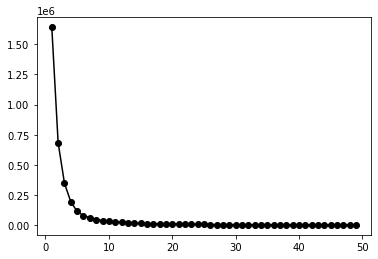

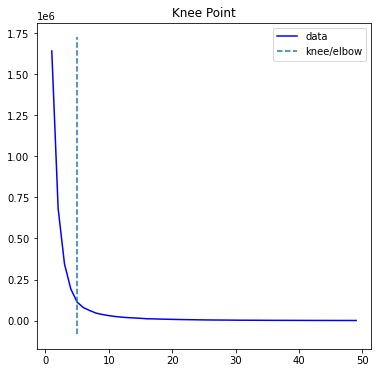

In [8]:
#Iterate through each batch of BATCHSIZE and Initiate and upload the groupings
for batch in range(0,batches):
    print("Batch #",batch," of ", batches-1, "\n\n")
    InitiateModel(randomKeyPairs[batch*BATCHSIZE:(batch+1)*BATCHSIZE],batch)

In [9]:
#Confirm uploads
print(storage.list(datasetName))

['updatedModel_state_sampled_happy_cowGroupBatch0', 'updatedModel_state_sampled_happy_cowHrBatch0', 'updatedModel_state_sampled_happy_cowLrBatch0']


In [10]:
"""
b=0
check = pkl.loads(decompress(storage.get('high_sampledworried_puppyGroupBatch2')))
for a in check:
    b+=len(check[a])
print(b)
#"""

1453


In [11]:
print('hi')

hi
